<h1 style="color: orange;">Model Comparison: RandomForest, GradientBoosting, XGBoost (Target Encoding)</h1>

<h2 style="color: green;">Introduction</h2>
<p style="color: gray;">
In this notebook, we evaluate and compare three advanced models—RandomForest, GradientBoosting, and XGBoost—using a Target Encoding strategy for categorical features. Target Encoding converts categorical variables into numerical values based on the distribution of the target variable, which is especially useful when dealing with high-cardinality features.
</p>

<h2 style="color: green;">Objectives</h2>
<ul style="color: gray;">
  <li>Preprocess the data by imputing missing values and applying Target Encoding to categorical features.</li>
  <li>Train and tune the models using techniques such as RandomizedSearchCV and GridSearchCV.</li>
  <li>Compare model performance using key metrics such as ROC AUC, F1 Macro, Accuracy, Recall, and Precision.</li>
  <li>Visualize results with ROC curves, confusion matrices, and other diagnostic plots.</li>
</ul>

<h2 style="color: green;">Dataset & Methodology</h2>
<p style="color: gray;">
The dataset includes both numerical and categorical variables. For the Target Encoding approach, missing values are imputed using the most frequent value before encoding. The preprocessed data is then used to train each model, which are optimized via randomized and grid searches.
</p>

<h2 style="color: green;">Let's Get Started!</h2>


<h3 style="color: Gray;"> 📌 1. Import libraries</h3>

In [33]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


import scipy.stats as st  # for continuous distributions in randomized search

<h3 style="color: Gray;"> 📌 2. Load Data & Define Target </h3>

In [2]:
#importing my pre-cleaned DF
df=pd.read_pickle("/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/exp_data.pkl")
df.head()

,State,Zip,BankState,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,MIS_Status,GrAppv,ApprovalMonth,NAICS_CODE
0,IN,47711,OH,1997,84,4,1.0,0,0,0,0,0.0,1.0,60000.0,0,60000.0,2,45
1,IN,46526,IN,1997,60,2,1.0,0,0,0,0,0.0,1.0,40000.0,0,40000.0,2,72
2,IN,47401,IN,1997,180,7,0.0,0,0,0,0,0.0,0.0,287000.0,0,287000.0,2,62
3,OK,74012,OK,1997,60,2,0.0,0,0,0,0,0.0,1.0,35000.0,0,35000.0,2,0
4,FL,32801,FL,1997,240,14,0.0,7,7,0,0,0.0,0.0,229000.0,0,229000.0,2,0


In [3]:
# 2. Define a helper function to convert binary columns
def convert_binary(X):
    X = X.copy()
    binary_cols = ["RevLineCr", "LowDoc", "NewExist"]
    for col in binary_cols:
        if col in X.columns:
            X[col] = X[col].astype(int)
    return X

In [30]:
#Data preparation
target = "MIS_Status"
X = df.drop(columns=[target])
y = df[target]

# Columns to impute (example columns)
cols_to_impute = ['State','RevLineCr', 'LowDoc', 'BankState', 'NewExist']
imputer = SimpleImputer(strategy='most_frequent')
X[cols_to_impute] = imputer.fit_transform(X[cols_to_impute])
# Assuming X is your feature DataFrame
X = convert_binary(X)

# Then split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Identify categorical columns (for target encoding)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

<h3 style="color: Gray;"> 📌 3. RandomizedSearchCV </h3>

In [7]:
# Define the base pipeline (we assume imputation/other steps are done outside if desired)
base_pipeline = Pipeline([
    ("target_encoder", TargetEncoder(cols=cat_cols, smoothing=0.3)),
    # ("convert_binary", FunctionTransformer(convert_binary)),  # Omit if already applied
    ("classifier", RandomForestClassifier(random_state=42))  # placeholder
])

# Define your models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

# Define a modified hyperparameter search space with narrower ranges
param_distributions = {
    "RandomForest": {
        "classifier__n_estimators": st.randint(100, 300),
        "classifier__max_depth": st.randint(3, 10),
        "classifier__min_samples_split": st.randint(2, 8),
        "classifier__min_samples_leaf": st.randint(1, 4),
        "classifier__bootstrap": [True, False]
    },
    "GradientBoosting": {
        "classifier__n_estimators": st.randint(50, 150),
        "classifier__learning_rate": st.uniform(0.01, 0.1),
        "classifier__max_depth": st.randint(3, 8)
    },
    "XGBoost": {
        "classifier__n_estimators": st.randint(50, 150),
        "classifier__learning_rate": st.uniform(0.01, 0.1),
        "classifier__max_depth": st.randint(3, 8),
        "classifier__subsample": [0.8, 1.0],
        "classifier__colsample_bytree": [0.8, 1.0]
    }
}

# Prepare a dictionary to store the results
results_random = {}

# Loop over each model to run RandomizedSearchCV and then evaluate on the test set
for model_name, model in models.items():
    print(f"🚀 Running RandomizedSearchCV for {model_name} ...")
    
    # Update the pipeline to use the current model
    pipeline = Pipeline(base_pipeline.steps[:-1] + [("classifier", model)])
    
    # Create the RandomizedSearchCV instance with reduced iterations and folds
    rs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions[model_name],
        n_iter=10,      # Fewer iterations for faster run
        cv=3,           # Fewer folds to reduce runtime
        scoring="roc_auc",
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit the model on the training set
    rs.fit(X_train, y_train)
    
    # Print and store the best parameters
    print(f"Best parameters from RandomizedSearch for {model_name}:")
    print(rs.best_params_)
    
    # Get the best model from the randomized search
    best_random_model = rs.best_estimator_
    
    # Evaluate the best model on the test set
    y_pred = best_random_model.predict(X_test)
    y_pred_proba = best_random_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)
    
    # Store the results for the current model
    results_random[model_name] = {
        "Best Randomized Model": best_random_model,
        "Best Randomized Params": rs.best_params_,
        "AUC": auc,
        "Report": report
    }
    
    print(f"\n🔹 {model_name} - AUC Score: {auc:.4f}")
    print(report)
    print("="*50, "\n")

🚀 Running RandomizedSearchCV for RandomForest ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters from RandomizedSearch for RandomForest:
{'classifier__bootstrap': True, 'classifier__max_depth': 8, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 154}

🔹 RandomForest - AUC Score: 0.9392
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     74135
           1       0.86      0.63      0.72     15782

    accuracy                           0.92     89917
   macro avg       0.89      0.80      0.84     89917
weighted avg       0.91      0.92      0.91     89917


🚀 Running RandomizedSearchCV for GradientBoosting ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters from RandomizedSearch for GradientBoosting:
{'classifier__learning_rate': np.float64(0.0831993941811405), 'classifier__max_depth': 7, 'classifier__n_estimators': 70}

🔹 Gradi

<h3 style="color: Gray;"> 📌 4. GridSearchCV </h3>

In [14]:
# Define a base pipeline (include additional steps if needed)
base_pipeline = Pipeline([
    ("target_encoder", TargetEncoder(cols=cat_cols, smoothing=0.3)),
    ("classifier", RandomForestClassifier(random_state=42))  # placeholder; will be updated below
])

# Define your models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

# Define refined grid search parameters based on RS insights.
param_grids = {
    "RandomForest": {
        "classifier__n_estimators": [100, 154, 160],
        "classifier__max_depth": [8],
        "classifier__min_samples_split": [5],
        "classifier__min_samples_leaf": [3],
        "classifier__bootstrap": [True]
    },
    "GradientBoosting": {
        "classifier__n_estimators": [50, 70, 100],
        "classifier__learning_rate": [ 0.083], 
        "classifier__max_depth": [7]
    },
    "XGBoost": {
        "classifier__n_estimators": [138, 150],
        "classifier__learning_rate": [0.0625],
        "classifier__max_depth": [6],
        "classifier__subsample": [0.8],
        "classifier__colsample_bytree": [0.8, 1.0]
    }
}

results_grid = {}  # Dictionary to store grid search results

for model_name, model in models.items():
    print(f"🚀 Running GridSearchCV for {model_name} ...")
    
    # Update the pipeline to use the current model
    pipeline = Pipeline(base_pipeline.steps[:-1] + [("classifier", model)])
    
    # Setup GridSearchCV
    gs = GridSearchCV(
        pipeline,
        param_grid=param_grids[model_name],
        cv=5,  # you can adjust folds if needed
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )
    
    # Fit GridSearchCV on the training data
    gs.fit(X_train, y_train)

    # Print and store the best parameters
    print(f"Best parameters from GriddSearch for {model_name}:")
    print(gs.best_params_)
    
    # Get the best estimator
    best_model = gs.best_estimator_
    
    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # Store the results
    results_grid[model_name] = {
        "Best Grid Model": best_model,
        "Best Grid Params": gs.best_params_,
        "AUC": auc,
        "Report": report,
        "Confusion Matrix": cm
    }
    
    print(f"\n🔹 {model_name} - AUC Score: {auc:.4f}")
    print(report)
    print("Confusion Matrix:")
    print(cm)
    print("="*50, "\n")

🚀 Running GridSearchCV for RandomForest ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters from GriddSearch for RandomForest:
{'classifier__bootstrap': True, 'classifier__max_depth': 8, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 154}

🔹 RandomForest - AUC Score: 0.9392
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     74135
           1       0.86      0.63      0.72     15782

    accuracy                           0.92     89917
   macro avg       0.89      0.80      0.84     89917
weighted avg       0.91      0.92      0.91     89917

Confusion Matrix:
[[72532  1603]
 [ 5912  9870]]

🚀 Running GridSearchCV for GradientBoosting ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters from GriddSearch for GradientBoosting:
{'classifier__learning_rate': 0.083, 'classifier__max_depth': 7, 'classifier__n_estimators': 100}

🔹 Grad

<h3 style="color: Gray;"> 📌 5. Exporting our models </h3>

In [18]:


# Define the export directory.
export_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/'

# Ensure the directory exists; if not, create it.
os.makedirs(export_dir, exist_ok=True)

# Assuming your grid search results are stored in the results_grid dictionary
# with keys like "RandomForest", "GradientBoosting", and "XGBoost".
for model_name, result in results_grid.items():
    best_model = result["Best Grid Model"]
    file_name = f"{model_name}_best_grid_model.pkl"
    export_path = os.path.join(export_dir, file_name)
    
    with open(export_path, "wb") as f:
        pickle.dump(best_model, f)
    
    print(f"Exported {model_name} best model to {export_path}")


Exported RandomForest best model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/RandomForest_best_grid_model.pkl
Exported GradientBoosting best model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/GradientBoosting_best_grid_model.pkl
Exported XGBoost best model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/XGBoost_best_grid_model.pkl


<h3 style="color: Gray;"> 📌 6. DataViz of our models </h3>

Plotting feature importances for RandomForest...


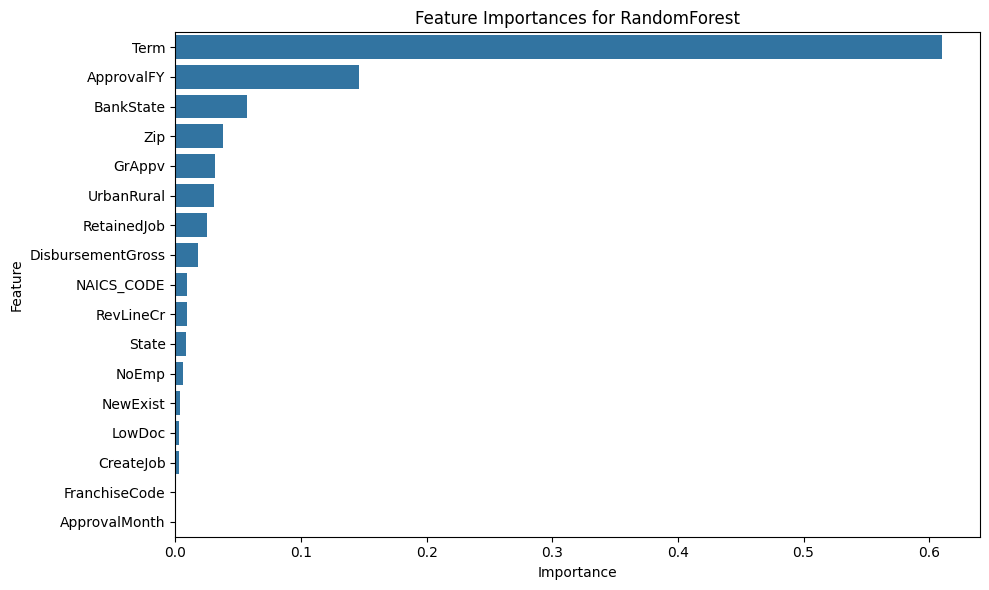

Plotting feature importances for GradientBoosting...


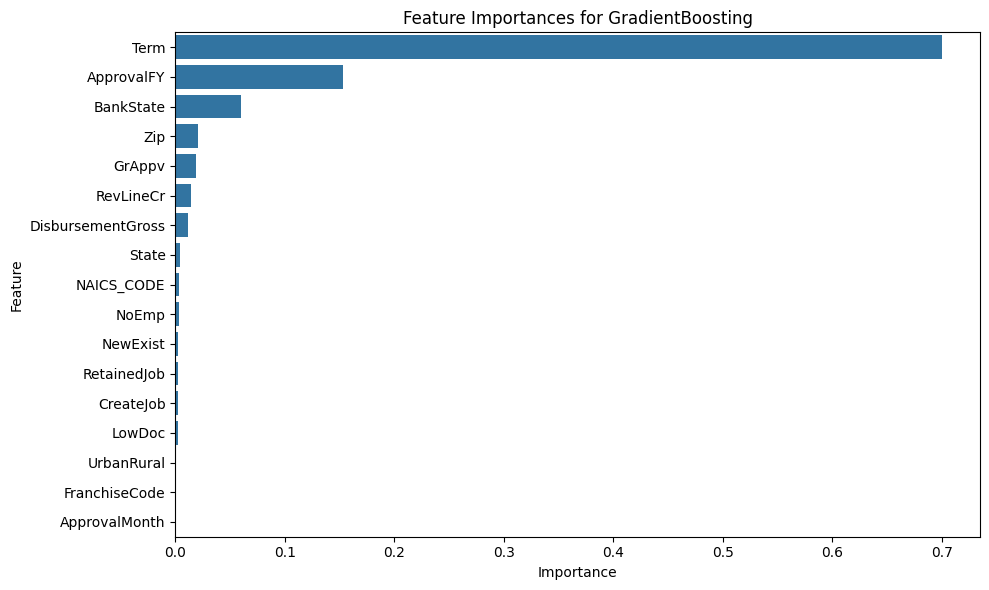

Plotting feature importances for XGBoost...


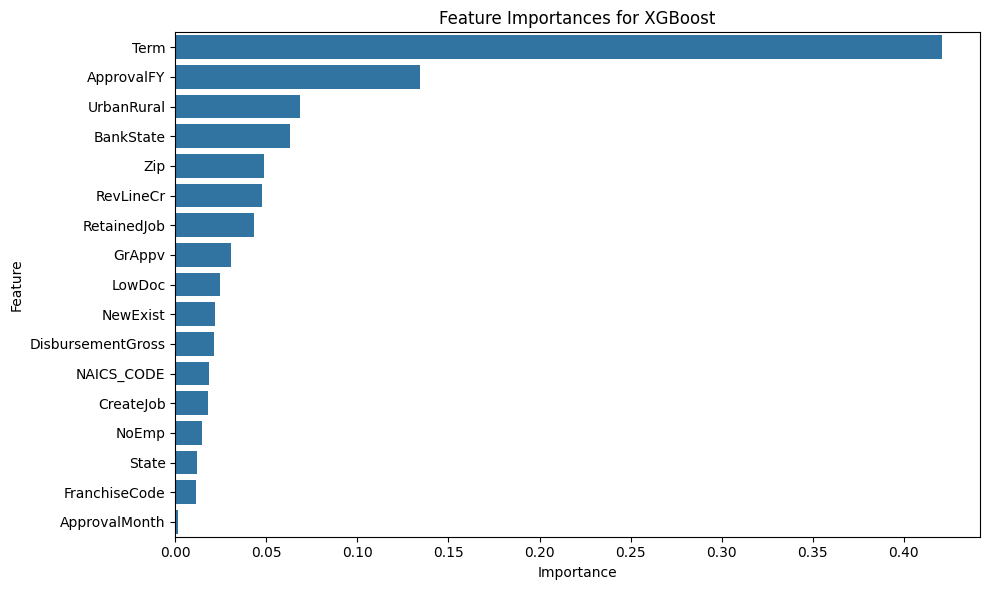

In [28]:


# Loop over each model in your grid search results
for model_name, result in results_grid.items():
    print(f"Plotting feature importances for {model_name}...")
    
    best_estimator = result["Best Grid Model"]
    classifier = best_estimator.named_steps["classifier"]
    
    if hasattr(classifier, "feature_importances_"):
        importances = classifier.feature_importances_
        
        # Try to extract feature names from a 'preprocessor' if available
        feature_names = None
        if "preprocessor" in best_estimator.named_steps:
            preprocessor = best_estimator.named_steps["preprocessor"]
            if hasattr(preprocessor, "get_feature_names_out"):
                feature_names = preprocessor.get_feature_names_out()
        
        # Fallback to X_train.columns if no preprocessor or method exists
        if feature_names is None:
            feature_names = X_train.columns
        
        # Check if lengths match; if not, print a warning
        if len(feature_names) != len(importances):
            print(f"Warning: Expected {len(importances)} feature names but got {len(feature_names)}. Adjust your extraction method.")
        
        feat_imp_df = pd.DataFrame({
            "Feature": feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
        plt.title(f"Feature Importances for {model_name}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
    else:
        print(f"The classifier for {model_name} does not support feature importances.")


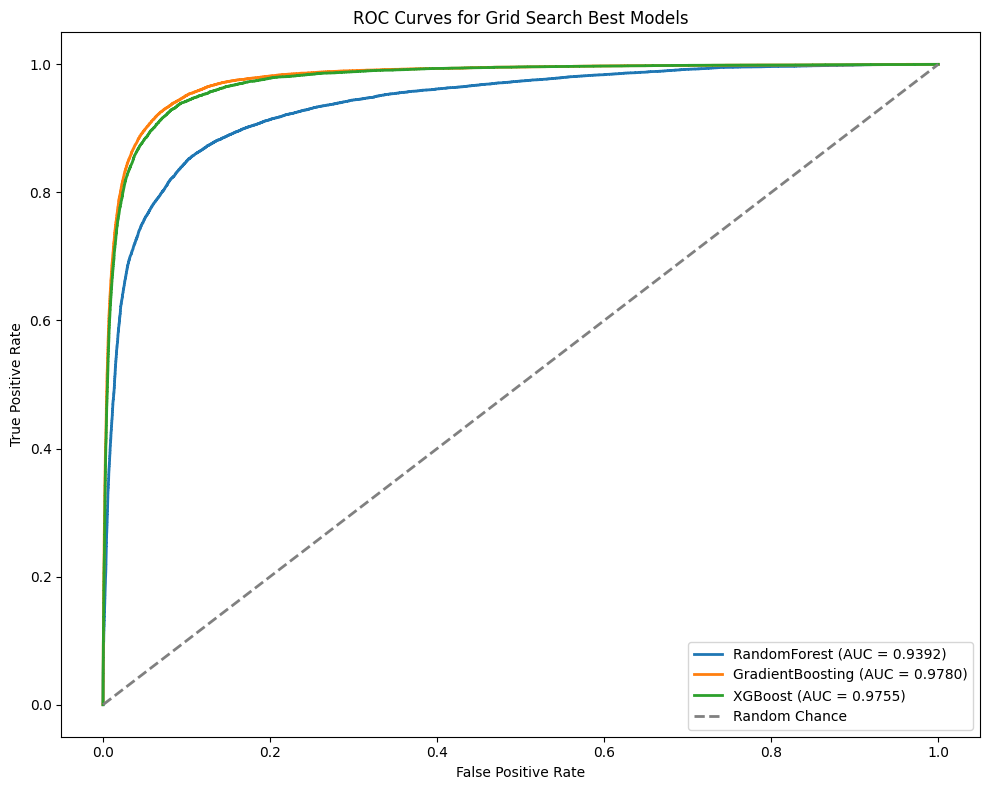

In [31]:


plt.figure(figsize=(10, 8))

# Loop over each model in your grid search results
for model_name, result in results_grid.items():
    best_model = result["Best Grid Model"]
    
    # Get predicted probabilities for the positive class on the test set
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    # Optionally, recalc AUC (should match result['AUC'])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for the model
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")

# Plot the random chance line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Grid Search Best Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


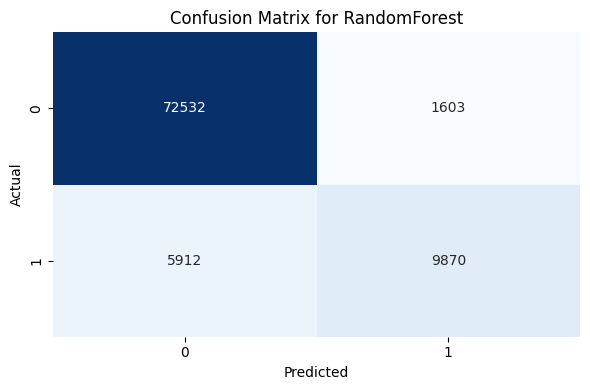

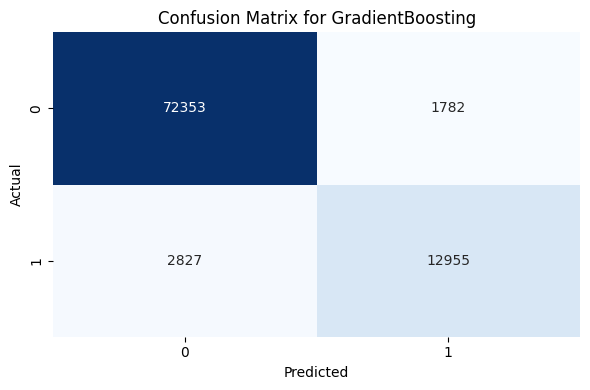

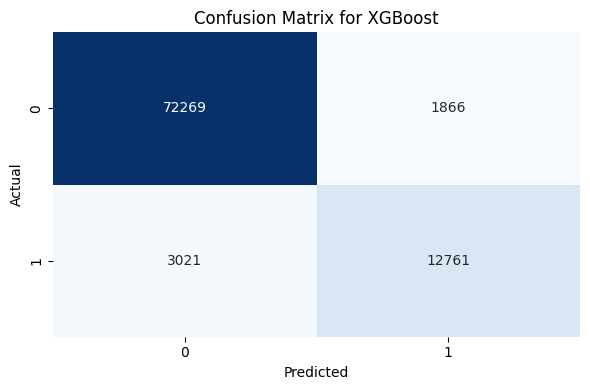

In [32]:
for model_name, result in results_grid.items():
    best_model = result["Best Grid Model"]
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()